# 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．


---



自然言語100本ノック　https://nlp100.github.io/ja/　\
解答解説　https://kakedashi-engineer.appspot.com/nlp100/


---



# **70. 単語ベクトルの和による特徴量**
- 問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xi
の特徴ベクトルxi
を並べた行列X
と，正解ラベルを並べた行列（ベクトル）Y
を作成したい

In [ ]:
# データのダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2024-01-05 03:54:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip.2’

NewsAggregatorDatas     [    <=>             ]  27.87M  36.4MB/s    in 0.8s    

2024-01-05 03:55:00 (36.4 MB/s) - ‘NewsAggregatorDataset.zip.2’ saved [29224203]

Archive:  NewsAggregatorDataset.zip
replace 2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())


【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [ ]:
#第7章の問題60でも利用した学習済み単語ベクトルをダウンロードし、ロード

!pip install -U --no-cache-dir gdown --pre

In [ ]:
import gdown
from gensim.models import KeyedVectors

# 学習済み単語ベクトルのダウンロード
url = "https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM"
output = 'GoogleNews-vectors-negative300.bin.gz'
gdown.download(url, output, quiet=True)

# ダウンロードファイルのロード
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

特徴ベクトルとラベルベクトルを作成し、保存。 なお、このあとPyTorchによるニューラルネットのインプットとして利用するため、Tensor型に変換。
Tensor型 Pytorchの用意した特殊な型。Numpyのndarrayと似ている。GPUで扱えるのが特徴。

In [ ]:
import string
import torch

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [ ]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([10684, 300])
tensor([[ 0.0837,  0.0056,  0.0068,  ...,  0.0751,  0.0433, -0.0868],
        [ 0.0272,  0.0266, -0.0947,  ..., -0.1046, -0.0489, -0.0092],
        [ 0.0577, -0.0159, -0.0780,  ..., -0.0421,  0.1229,  0.0876],
        ...,
        [ 0.0392, -0.0052,  0.0686,  ..., -0.0175,  0.0061, -0.0224],
        [ 0.0798,  0.1017,  0.1066,  ..., -0.0752,  0.0623,  0.1138],
        [ 0.1664,  0.0451,  0.0508,  ..., -0.0531, -0.0183, -0.0039]])


In [117]:
X_valid.shape

torch.Size([1336, 300])

In [ ]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
#CATEGORY列の各要素が、category_dictによってマップされ、新たなシリーズとして取得され、
#さらに、.valueでNumpy配列にしてから、tensor型にしている。ややこしい。
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)


torch.Size([10684])
tensor([0, 1, 3,  ..., 0, 3, 2])


# 71. 単層ニューラルネットワークによる予測

In [ ]:
from torch import nn

class SLPNet(nn.Module):
  #使用するオブジェクトを定義していく
  def __init__(self, input_size, output_size):
    super().__init__()
    #書き方の決まり
    self.fc = nn.Linear(input_size, output_size, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

  #順伝播
  def forward(self, x):
    x = self.fc(x)
    return x

In [ ]:
torch.manual_seed(0)

#インスタンス化
model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1) #最後の次元に対してsoftmaxを適用する。(今回は1×4だから最後の次元は4)
print(y_hat_1) #未学習の行列Wでx1を分類したときに各カテゴリに属する確率

tensor([[0.4273, 0.0958, 0.2492, 0.2277]], grad_fn=<SoftmaxBackward0>)


In [ ]:
model

SLPNet(
  (fc): Linear(in_features=300, out_features=4, bias=False)
)

In [ ]:
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat) #x1～x4を分類したときに各カテゴリに属する確率

tensor([[0.4273, 0.0958, 0.2492, 0.2277],
        [0.2445, 0.2431, 0.0197, 0.4927],
        [0.7853, 0.1132, 0.0291, 0.0724],
        [0.5279, 0.2319, 0.0873, 0.1529]], grad_fn=<SoftmaxBackward0>)


# 72. 損失と勾配の計算
- 学習データの事例x1
と事例集合x1,x2,x3,x4
に対して，クロスエントロピー損失と，行列W
に対する勾配を計算せよ．

nnパッケージのCrossEntropyLossを使用する。これを用いることで、最後の次元の平均損失を計算することができる。

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
l_1 = criterion(model(X_train[:1]), y_train[:1])  # 損失を計算。入力ベクトルはsoftmax前の値
model.zero_grad()  # 勾配をゼロで初期化←初期状態ではNoneだった
l_1.backward()  # 勾配を計算。誤差逆伝播法かな
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 0.8503
勾配:
tensor([[-0.0479, -0.0032, -0.0039,  ..., -0.0430, -0.0248,  0.0497],
        [ 0.0080,  0.0005,  0.0007,  ...,  0.0072,  0.0041, -0.0083],
        [ 0.0208,  0.0014,  0.0017,  ...,  0.0187,  0.0108, -0.0216],
        [ 0.0190,  0.0013,  0.0016,  ...,  0.0171,  0.0099, -0.0198]])


In [ ]:
l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 1.8321
勾配:
tensor([[-0.0063,  0.0042, -0.0139,  ..., -0.0272,  0.0201,  0.0263],
        [-0.0047, -0.0025,  0.0195,  ...,  0.0196,  0.0160,  0.0009],
        [ 0.0184, -0.0110, -0.0148,  ...,  0.0070, -0.0055, -0.0001],
        [-0.0074,  0.0092,  0.0092,  ...,  0.0006, -0.0306, -0.0272]])


# 73. 確率的勾配降下法による学習Permalink
- 確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W
を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

学習に当たり、DatasetとDataloaderを準備。 Datasetは特徴ベクトルとラベルベクトルを合わせて保持することができる型で、以下のクラスを用いてもとのTensorを変換する。

In [ ]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
  def __init__(self, X, y):  # datasetの構成要素を指定
    self.X = X
    self.y = y

  def __len__(self):  # len(dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, idx):  # dataset[idx]で返す値を指定
    return [self.X[idx], self.y[idx]]

変換後、DataLoaderを作成。DataloaderはDatasetを入力とし、指定したサイズ(batch_size)にまとめたデータを順に取り出すことができる。ここではbatch_size=1としているので、1つずつデータを取り出すDataloaderを作成することを意味。 なお、Dataloaderはfor文で順に取り出すか、またはnext(iter(Dataloader))で次のかたまりを呼び出すことが可能。

> インデントされたブロック

In [ ]:
from torch.utils.data import DataLoader

# Datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)


データの準備ができたので、行列W を学習。 モデルの定義、損失関数の定義は前問と同様です。今回は計算した勾配から重みも更新するため、オプティマイザも定義。ここでは指示に従いSGDをセットしていく。

- 対象の設定や構造などを調整し、より好ましい状態に組み替える「最適化」（optimization）を行うためのソフトウェアや機能のこと。

In [ ]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 損失を記録
    loss_train += loss.item()

  # バッチ単位の平均損失計算
  loss_train = loss_train / i

  # 検証データの損失計算
  model.eval()
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
    loss_valid = criterion(outputs, labels)

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')

epoch: 1, loss_train: 0.4527, loss_valid: 0.3751
epoch: 2, loss_train: 0.3061, loss_valid: 0.3292
epoch: 3, loss_train: 0.2799, loss_valid: 0.3206
epoch: 4, loss_train: 0.2650, loss_valid: 0.3146
epoch: 5, loss_train: 0.2558, loss_valid: 0.3075
epoch: 6, loss_train: 0.2482, loss_valid: 0.3109
epoch: 7, loss_train: 0.2433, loss_valid: 0.3063
epoch: 8, loss_train: 0.2388, loss_valid: 0.3059
epoch: 9, loss_train: 0.2359, loss_valid: 0.3062
epoch: 10, loss_train: 0.2324, loss_valid: 0.3075


# 74. 正解率の計測
- 問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [ ]:
#学習したモデルとDataloaderを入力として、正解率を算出する関数を定義
def calculate_accuracy(model, loader):
  model.eval() #モデルの挙動が学習モードから評価モードに変更
  total = 0
  correct = 0
  with torch.no_grad(): #評価の際は勾配情報が不要であり、逆伝播の計算を行わないことで無駄な計算を避けることができる。
    for inputs, labels in loader:
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return correct / total

In [ ]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.924
正解率（評価データ）：0.903


# 75. 損失と正解率のプロット
- 問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [ ]:
#前問の関数を損失も計算できるように改変し、エポック毎に適用することで損失と正解率を記録
def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

In [ ]:

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

     # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_vaild:  {acc_valid:.4f}')

epoch: 1, loss_train: 0.3360, accuracy_train: 0.8881, loss_valid: 0.3615, accuracy_vaild:  0.8802
epoch: 2, loss_train: 0.2862, accuracy_train: 0.9065, loss_valid: 0.3240, accuracy_vaild:  0.8885
epoch: 3, loss_train: 0.2662, accuracy_train: 0.9126, loss_valid: 0.3117, accuracy_vaild:  0.8937
epoch: 4, loss_train: 0.2554, accuracy_train: 0.9155, loss_valid: 0.3106, accuracy_vaild:  0.8967
epoch: 5, loss_train: 0.2454, accuracy_train: 0.9184, loss_valid: 0.3046, accuracy_vaild:  0.8990
epoch: 6, loss_train: 0.2423, accuracy_train: 0.9160, loss_valid: 0.3099, accuracy_vaild:  0.8960
epoch: 7, loss_train: 0.2345, accuracy_train: 0.9227, loss_valid: 0.3042, accuracy_vaild:  0.8990
epoch: 8, loss_train: 0.2334, accuracy_train: 0.9219, loss_valid: 0.3047, accuracy_vaild:  0.8952
epoch: 9, loss_train: 0.2270, accuracy_train: 0.9247, loss_valid: 0.3019, accuracy_vaild:  0.8967
epoch: 10, loss_train: 0.2327, accuracy_train: 0.9213, loss_valid: 0.3135, accuracy_vaild:  0.8937
epoch: 11, loss_tra

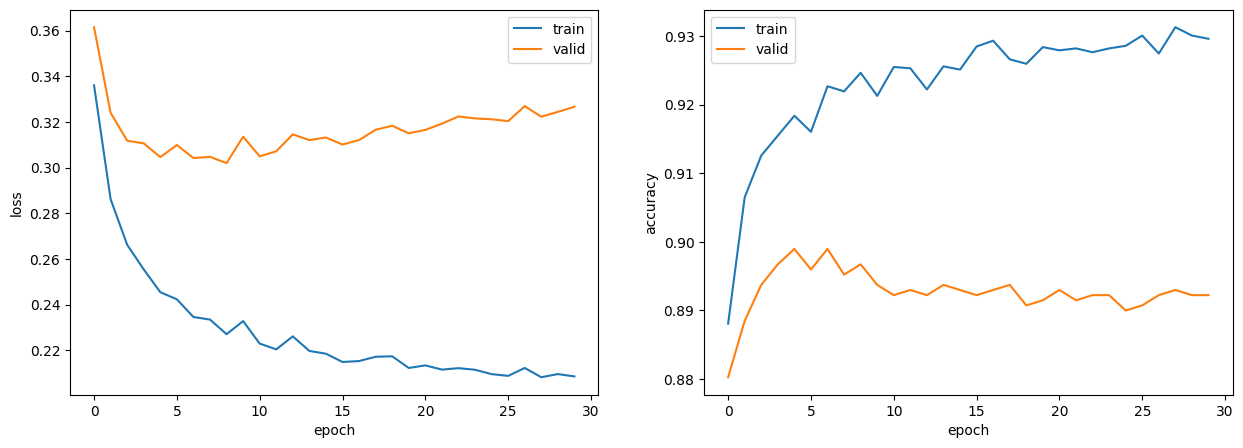

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

# 76. チェックポイント
- 問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

学習途中のパラメータはmodel.state_dict()、最適化アルゴリズムの内部状態はoptimizer.state_dict()でアクセス可能なため、各エポックでエポック数と合わせて保存する処理を追加。 なお、出力は前問と同様。

In [ ]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # チェックポイントの保存
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_vaild:  {acc_valid:.4f}')


epoch: 1, loss_train: 0.3256, accuracy_train: 0.8869, loss_valid: 0.3526, accuracy_vaild:  0.8780
epoch: 2, loss_train: 0.2851, accuracy_train: 0.9046, loss_valid: 0.3273, accuracy_vaild:  0.8892
epoch: 3, loss_train: 0.2680, accuracy_train: 0.9113, loss_valid: 0.3195, accuracy_vaild:  0.8915
epoch: 4, loss_train: 0.2520, accuracy_train: 0.9136, loss_valid: 0.3080, accuracy_vaild:  0.8975
epoch: 5, loss_train: 0.2442, accuracy_train: 0.9175, loss_valid: 0.3066, accuracy_vaild:  0.8997
epoch: 6, loss_train: 0.2384, accuracy_train: 0.9220, loss_valid: 0.3076, accuracy_vaild:  0.8982
epoch: 7, loss_train: 0.2334, accuracy_train: 0.9225, loss_valid: 0.3077, accuracy_vaild:  0.9012
epoch: 8, loss_train: 0.2309, accuracy_train: 0.9219, loss_valid: 0.3083, accuracy_vaild:  0.8930
epoch: 9, loss_train: 0.2267, accuracy_train: 0.9235, loss_valid: 0.3079, accuracy_vaild:  0.8945
epoch: 10, loss_train: 0.2308, accuracy_train: 0.9226, loss_valid: 0.3134, accuracy_vaild:  0.8922


# 77. ミニバッチ化
- 問題76のコードを改変し，B
事例ごとに損失・勾配を計算し，行列W
の値を更新せよ（ミニバッチ化）．B
の値を1,2,4,8,…
と変化させながら，1エポックの学習に要する時間を比較せよ．

バッチサイズを変えるごとにすべての処理を書くのは大変なので、Dataloaderの作成以降の処理をtrain_modelとして関数化し、バッチサイズを含むいくつかのパラメータを引数として設定。

In [ ]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()


    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}


バッチサイズを変えながら、処理時間を計測

In [ ]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.3267, accuracy_train: 0.8887, loss_valid: 0.3520, accuracy_valid: 0.8780, 6.9054sec
バッチサイズ: 2
epoch: 1, loss_train: 0.2992, accuracy_train: 0.8973, loss_valid: 0.3292, accuracy_valid: 0.8832, 3.5461sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2899, accuracy_train: 0.9008, loss_valid: 0.3242, accuracy_valid: 0.8870, 2.0910sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2861, accuracy_train: 0.9016, loss_valid: 0.3219, accuracy_valid: 0.8900, 1.3737sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2846, accuracy_train: 0.9028, loss_valid: 0.3208, accuracy_valid: 0.8892, 0.6948sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2835, accuracy_train: 0.9026, loss_valid: 0.3203, accuracy_valid: 0.8907, 0.3946sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2831, accuracy_train: 0.9029, loss_valid: 0.3201, accuracy_valid: 0.8900, 0.2710sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2826, accuracy_train: 0.9028, loss_valid: 0.3199, accuracy_valid: 0.8900, 0.2017sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2823, accuracy_

78. **GPU上での学習Permalink**
- 問題77のコードを改変し，GPU上で学習を実行せよ



```
torch.cuba.is_available()
```



GPUを指定する引数deviceをcalculate_loss_and_accuracy、train_modelに追加する。 それぞれの関数内で、モデルおよび入力TensorをGPUに送る処理を追加し、deviceにcudaを指定すればGPUを使用することができる。

In [ ]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device = torch.device):
  # GPUに送る
  model.to(device)

    # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()


    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}


In [ ]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1, device=device)

バッチサイズ: 1
epoch: 1, loss_train: 0.3236, accuracy_train: 0.8898, loss_valid: 0.3492, accuracy_valid: 0.8780, 13.4116sec
バッチサイズ: 2
epoch: 1, loss_train: 0.2959, accuracy_train: 0.8991, loss_valid: 0.3303, accuracy_valid: 0.8877, 6.5970sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2879, accuracy_train: 0.9015, loss_valid: 0.3245, accuracy_valid: 0.8945, 3.7843sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2837, accuracy_train: 0.9034, loss_valid: 0.3222, accuracy_valid: 0.8922, 1.7954sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2819, accuracy_train: 0.9042, loss_valid: 0.3205, accuracy_valid: 0.8915, 0.9677sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2811, accuracy_train: 0.9047, loss_valid: 0.3201, accuracy_valid: 0.8930, 0.5560sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2807, accuracy_train: 0.9047, loss_valid: 0.3198, accuracy_valid: 0.8915, 0.3804sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2809, accuracy_train: 0.9047, loss_valid: 0.3197, accuracy_valid: 0.8915, 0.2695sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2804, accuracy

# 79. 多層ニューラルネットワーク
- 問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

多層ニューラルネットワークMLPNetを新たに定義する。このネットワークは入力層 -> 中間層 -> 出力層の構成とし、中間層のあとにバッチノーマライゼーションを行うことととする。 また、train_modelでは新たに学習の打ち切り基準を導入し、今回はシンプルに、検証データの損失が3エポック連続で低下しなかった場合に打ち切るルールとする。 さらに、学習率を徐々に下げるスケジューラも追加し、汎化性能の向上を狙います。

In [ ]:
from torch.nn import functional as F

class MLPNet(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size)
    self.bn = nn.BatchNorm1d(mid_size)#中間層の出力サイズ mid_size に対してバッチ正規化を行う
    #バッチ正規化とは、各ミニバッチ内での入力の平均を0にし、標準偏差を1にする正規化である。

  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))

    return x

In [ ]:
from torch import optim

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # スケジューラの設定 (局所的な最適解を避ける効果が期待されるスケジューラ。学習率を上げるらしい。)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

     # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}




In [ ]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = MLPNet(300, 200, 4, 1)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, 64, model, criterion, optimizer, 1000, device)

epoch: 1, loss_train: 1.0387, accuracy_train: 0.6754, loss_valid: 1.0333, accuracy_valid: 0.6751, 1.0427sec
epoch: 2, loss_train: 0.7660, accuracy_train: 0.7595, loss_valid: 0.7637, accuracy_valid: 0.7590, 0.5208sec
epoch: 3, loss_train: 0.6621, accuracy_train: 0.7732, loss_valid: 0.6627, accuracy_valid: 0.7732, 0.6452sec
epoch: 4, loss_train: 0.6078, accuracy_train: 0.7862, loss_valid: 0.6102, accuracy_valid: 0.7837, 0.6999sec
epoch: 5, loss_train: 0.5668, accuracy_train: 0.7995, loss_valid: 0.5709, accuracy_valid: 0.8001, 0.6838sec
epoch: 6, loss_train: 0.5342, accuracy_train: 0.8112, loss_valid: 0.5408, accuracy_valid: 0.8084, 0.9577sec
epoch: 7, loss_train: 0.5072, accuracy_train: 0.8190, loss_valid: 0.5155, accuracy_valid: 0.8211, 0.5635sec
epoch: 8, loss_train: 0.4846, accuracy_train: 0.8294, loss_valid: 0.4958, accuracy_valid: 0.8263, 0.5090sec
epoch: 9, loss_train: 0.4607, accuracy_train: 0.8385, loss_valid: 0.4737, accuracy_valid: 0.8338, 0.5296sec
epoch: 10, loss_train: 0.440

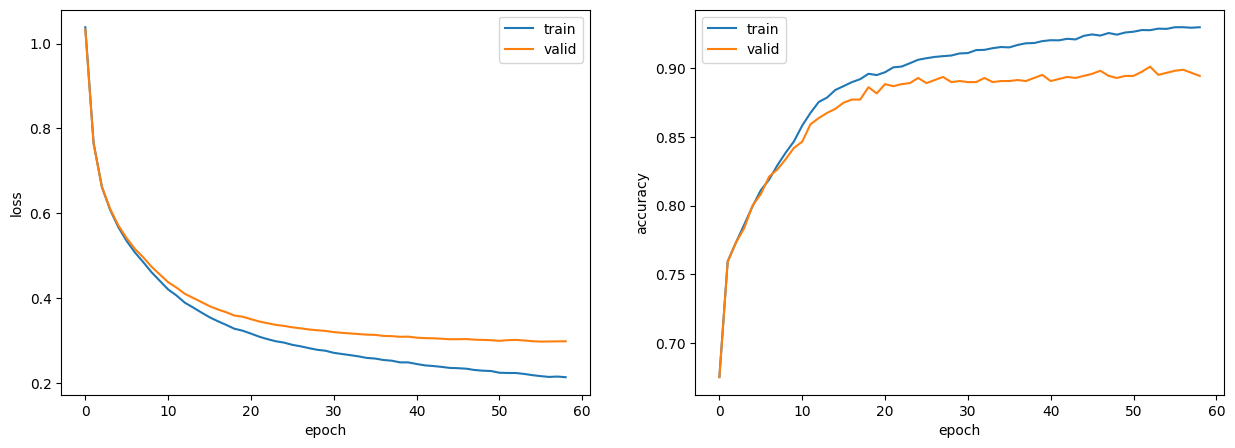

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log['train']).T[0], label='train')
ax[0].plot(np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log['train']).T[1], label='train')
ax[1].plot(np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [ ]:
def calculate_accuracy(model, loader, device):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return correct / total

In [ ]:
# 正解率の確認
acc_train = calculate_accuracy(model, dataloader_train, device)
acc_test = calculate_accuracy(model, dataloader_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.930
正解率（評価データ）：0.910
